In [1]:
import json
import os
from collections import defaultdict
from os import path as op
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from mne import EvokedArray

# from mne.epochs import concatenate_epochs
from mne.decoding import (
    LinearModel,
    SlidingEstimator,  # GeneralizingEstimator,
    cross_val_multiscore,
    get_coef,
)
from mne.stats import f_mway_rm, f_threshold_mway_rm, permutation_cluster_1samp_test
from mne.datasets import fetch_fsaverage
from numpy.lib.npyio import load
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from vr2f import helpers
from vr2f.staticinfo import COLORS, CONFIG, PATHS

In [2]:
def load_decod_res_per_viewcond(
    sub_list_str,
    conditions,
    vc_list=[],
    scoring="accuracy",
    picks_str=None,
    gen_str=None,
):
    data_dict = dict()
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ""

    if gen_str is not None:
        gen_folder = gen_str
    else:
        gen_folder = ""

    if len(vc_list) == 0:
        vc_list = [""]

    paths = PATHS()

    contrast_str = "_vs_".join(conditions)

    for vc in vc_list:
        data_dict[vc] = dict(scores=[], times=[], patterns=[])
        for subID in sub_list_str:
            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                vc,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[vc]["scores"].append(scores_)

            if len(data_dict[vc]["times"]) == 0:
                data_dict[vc]["times"] = np.load(str(fname)[:-4] + "__times" + ".npy")
            else:
                assert np.all(data_dict[vc]["times"] == np.load(str(fname)[:-4] + "__times" + ".npy"))

            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                vc,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "patterns",
            )
            fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
            patterns_ = np.load(fname)
            data_dict[vc]["patterns"].append(patterns_)

        data_dict[vc]["scores"] = np.array(data_dict[vc]["scores"])
        data_dict[vc]["patterns"] = np.array(data_dict[vc]["patterns"])

    return data_dict


def load_patterns(
    sub_list_str,
    contrast_str,
    viewcond="",
    scoring="accuracy",
    reg="",
    labels_shuffled=False,
):
    """
    Load the patterns from sensor space decoding.

    Parameters
    ----------
    sub_list_str : list, str
        List of subject IDs to load patterns from.
    contrast_str : str
        Decoded contrast.
    viewcond : str
        Viewing condition. 'mono', 'stereo', or ''(default) for data pooled across both viewing conditions.
    scoring: str
        Scoring metric used during decoding. "roc_auc", accuracy" (default), or "balanced_accuracy";
    reg: str, float
        Regularization method used; Ints are interpreted as fixed shrinkage values; defaults to an empty string
    labels_shuffled : bool
        Allows to load the data from the run with shuffled labels.


    Returns
    -------
    patterns: ndarray
        Array with the patterns (subs x csp_components x channels x freqs x times)
    times: array, 1d

    """
    paths = PATHS()

    if isinstance(reg, float):
        reg_str = "shrinkage" + str(reg)
    else:
        reg_str = reg
    shuf_labs = "labels_shuffled" if labels_shuffled else ""

    patterns_list = []
    times = []

    for subID in sub_list_str:
        fpath = Path(paths.DATA_04_DECOD_SENSORSPACE, viewcond, contrast_str, scoring, "patterns")
        fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
        patterns_ = np.load(fname)
        patterns_list.append(patterns_)
        if len(times) == 0:
            times = np.load(str(fname)[:-4] + "__times" + ".npy")
        else:
            assert np.all(
                times == np.load(str(fname)[:-4] + "__times" + ".npy")
            ), "Times are different between subjects."

    patterns = np.concatenate(patterns_list)
    return patterns, times


def get_info(return_inst=False):
    paths = PATHS()
    fname = Path(
        paths.DATA_03_AR,
        "cleaneddata",
        "VR2FEM_S01-postAR-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)

    if return_inst:
        return epos.info, epos
    else:
        return epos.info


def get_epos(subID):
    paths = PATHS()
    fname = Path(
        paths.DATA_03_AR,
        "cleaneddata",
        f"{subID}-postAR-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    epos = epos.set_eeg_reference("average", projection=True)
    return epos


def l2norm(vec):
    out = np.sqrt(np.sum(vec**2))
    return out


def run_cbp_test(data, tail=0):
    # number of permutations to run
    n_permutations = 10000
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = tail  # 1 or -1 for one-sided test, 0 for two-sided

    config = CONFIG()

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.N_JOBS,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return T_obs, clusters, cluster_p_values


def plot_score_per_factor(
    factor,
    data,
    scoring="accuracy",
    sign_clusters=[],
    p_lvl=0.05,
    chancelvl=0.5,
    ylims=None,
    xlims=None,
    ax=None,
    n_boot=1000,
):
    colors = COLORS()

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        palette=colors.COLDICT,
        ax=ax,
        linewidth=1.5,
        legend=False,
        errorbar="se",
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=xlims, ylim=ylims)
    if scoring == "roc_auc":
        scoring_str = "ROC AUC"
    else:
        scoring_str = scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")

    ax.text(x=1.0, y=chancelvl + 0.001, s="chance", ha="right")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.vlines(
        (0),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        chancelvl,
        xmin=xlims[0],
        xmax=xlims[1],
        linewidth=0.5,
        color="black",
    )
    p_lvl_str = "$p$ < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = colors.COLDICT[key.lower()]
            for sc in sign_clusters[key.lower()]:
                xmin = sc[0]
                xmax = sc[-1]
                y_ = ylims[0] + (0.01 - ((i + 1) * 0.025) * np.ptp(ylims))
                ax.hlines(
                    y_,
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )
            if i == 0:
                ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            y_ = ytick_range[0] + 0.05 * np.ptp(ytick_range)
            ax.hlines(
                y_,
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
        if len(sign_clusters) > 0:
            ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    # ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])


def prep_and_plot_from_data(data_dict, subsets, ax, chancelvl=0.25, ylims=(0.2, 0.32), scoring="roc_auc"):
    # Prepare data for plotting with seaborn:
    results_df_list = list()
    for vc in subsets:
        times = data_dict[vc]["times"]
        acc = np.asarray(data_dict[vc]["scores"])
        acc_df = pd.DataFrame(acc)
        acc_df.columns = times
        df = acc_df.melt(var_name="time", value_name="score")  # put into long format
        df["vc"] = vc
        results_df_list.append(df)
    data_plot = pd.concat(results_df_list)

    sign_cluster_times = {}
    # run CBP to find differences from chance:
    for vc in subsets:
        data = np.asarray(data_dict[vc]["scores"]) - chancelvl
        t_values, clusters, p_values = run_cbp_test(data, tail=1)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times[vc] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]

    if len(subsets) == 2:
        # run CBP to find difference between conditions:
        data = np.asarray(data_dict[subsets[0]]["scores"]) - np.asarray(data_dict[subsets[1]]["scores"])
        t_values, clusters, p_values = run_cbp_test(data, tail=0)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times["diff"] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]
        if len(sign_cluster_times["diff"]) > 0:
            helpers.print_msg("Found significant difference between conditions! Do you see that?")

    # Plot it:

    plot_score_per_factor(
        factor="vc",
        data=data_plot.reset_index(),
        scoring=scoring,
        sign_clusters={ecc: sign_cluster_times[ecc] for ecc in subsets},
        p_lvl=p_val_cbp,
        chancelvl=chancelvl,
        ylims=ylims,
        xlims=(-0.3, 1.0),
        n_boot=10000,
        ax=ax,
    )

In [3]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({"font.size": 16})
cm = 1 / 2.54

# plotting:

p_val_cbp = 0.05

paths = PATHS()
path_in = Path(paths.DATA_03_AR, "cleaneddata")

# load data
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]

## Multiclass decoding "emotion"

First pooled across the two viewing conditions:

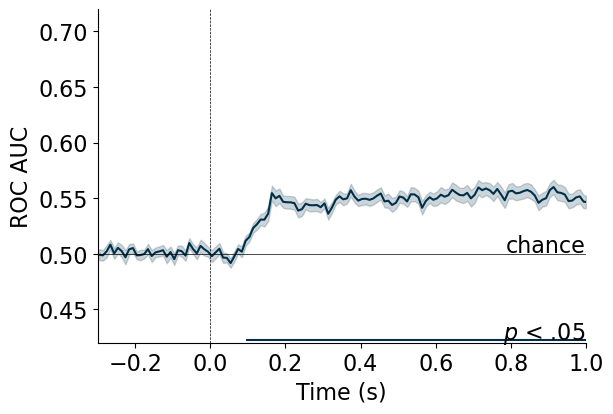

In [4]:
data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(data_dict_allemos, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.42, 0.72))

In [5]:
data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list= ["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")

Now per viewing condition:

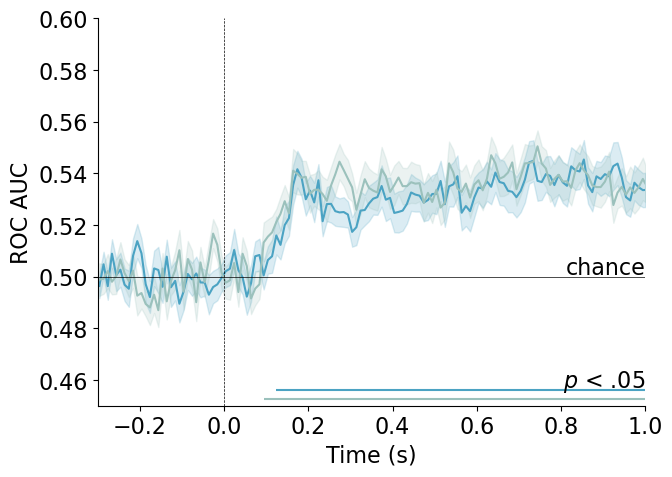

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

prep_and_plot_from_data(
    data_dict=data_dict_allemos,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.60),
)

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.9, top=0.9)

# leave more space around the plot:


fig.savefig(
    Path(paths.FIGURES, "decod_emo-all_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

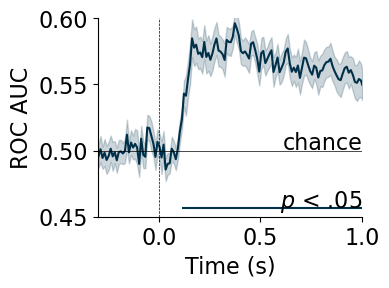

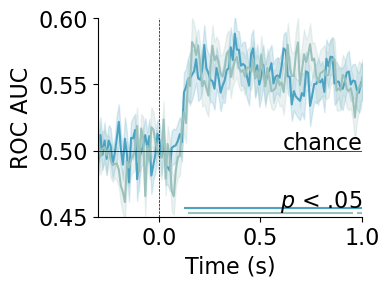

In [7]:
## Contrast: angry-happy

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["angry", "happy"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_na["all"] = data_dict_na.pop("")

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-happy_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-happy_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

## Binary Contrasts
Now we look into decoding binary comparisons of emotions.

### 1. Angry vs neutral

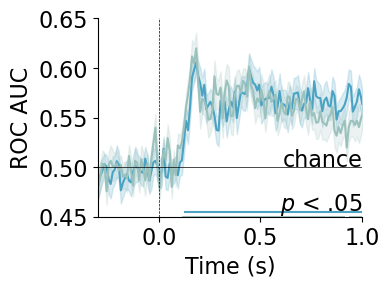

In [8]:
## Contrast: angry-neutral

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["angry", "neutral"],
    vc_list=["mono", "stereo"],
    scoring="roc_auc_ovr",
)
if "" in data_dict_na:
    data_dict_na["all"] = data_dict_na.pop("")

if "all" in data_dict_na:
    fig, ax = plt.subplots(1, 1, figsize=(8.0 * cm, 6.0 * cm))
    prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

    fig.savefig(
        Path(paths.FIGURES, "decod_angry-vs-neutral_all.pdf"),
        transparent=True,  # bbox_inches="tight"
    )


fig, ax = plt.subplots(1, 1, figsize=(8.0 * cm, 6.0 * cm))

prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-neutral_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

### 2. Surprised vs angry

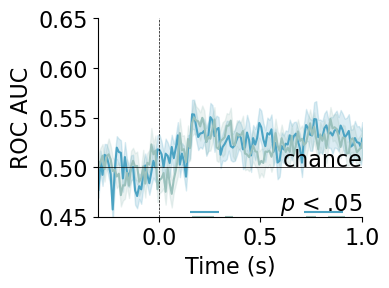

In [9]:
## Contrast: sursprised-angry

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["angry", "surprised"],
    vc_list=["mono", "stereo"],
    scoring="roc_auc_ovr",
)
if "" in data_dict_na:
    data_dict_na["all"] = data_dict_na.pop("")

if "all" in data_dict_na:
    fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
    prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

    fig.savefig(
        Path(paths.FIGURES, "decod_angry-vs-surpr_all.pdf"),
        transparent=True,  # bbox_inches="tight"
    )

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-surpr_mono-vs-stereo.pdf"),
    transparent=True,  #  bbox_inches="tight"
)

### 3. Contrast: Happy vs neutral

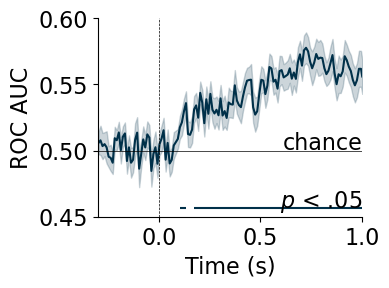

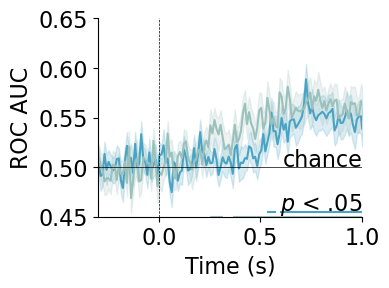

In [10]:
## Contrast: happy vs neutral

data_dict_hn = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["happy", "neutral"],
    vc_list=["mono", "stereo", ""],
    scoring="roc_auc_ovr",
)

if "" in data_dict_hn:
    data_dict_hn["all"] = data_dict_hn.pop("")

if "all" in data_dict_hn:
    fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
    prep_and_plot_from_data(data_dict_hn, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

    fig.savefig(
        Path(paths.FIGURES, "decod_happy-vs-neutral_all.pdf"),
        transparent=True,  # bbox_inches="tight"
    )


fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_hn,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(Path(paths.FIGURES, "decod_happy-vs-neutral_mono-vs-stereo.pdf"), transparent=True, bbox_inches="tight")

### 4. Contrast: Surprised vs Neutral

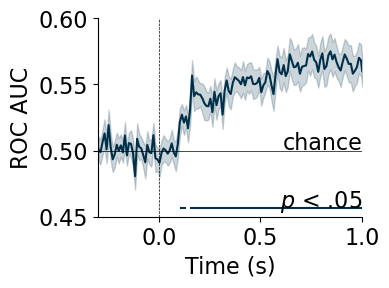

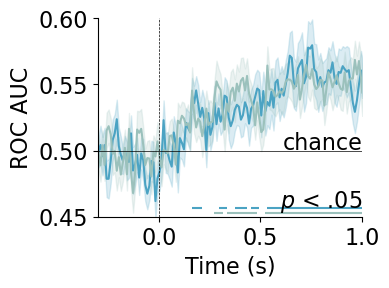

In [11]:
## Contrast: sursprised-neutral

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["surprised", "neutral"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_na["all"] = data_dict_na.pop("")

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_surpr-vs-neutral_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_supr-vs-neutral_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

## Decoding the viewing condition
Now we see whether we can decode (across all emotions) whether we can decode in which `viewing condition` a trial was shown.

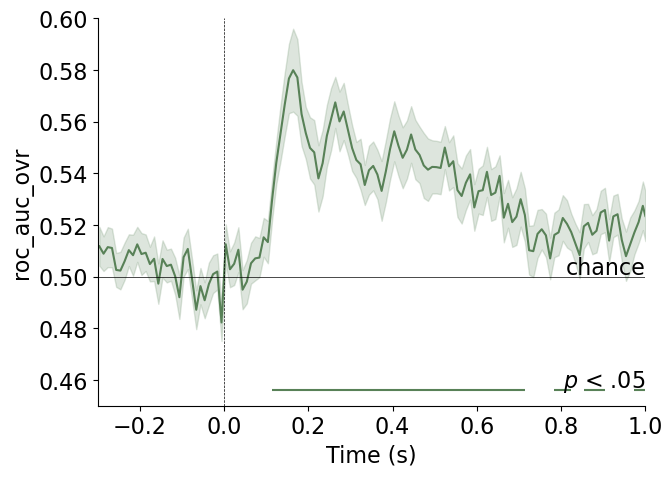

In [12]:
data_dict_vc = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["mono", "stereo"],
    vc_list=[""],
    scoring="roc_auc_ovr",
)
data_dict_vc["viewcond"] = data_dict_vc.pop("")

fig, ax = plt.subplots(1, figsize=(18.8 * cm, 13.3 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_vc,
    subsets=["viewcond"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
    scoring="roc_auc_ovr",
)

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.9, top=0.9)

fig.savefig(
    Path(paths.FIGURES, "decod_mono-vs-stereo_emo-all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

### 5. Contrast: Angry vs Happy

## (Implicit) Decoding Identity

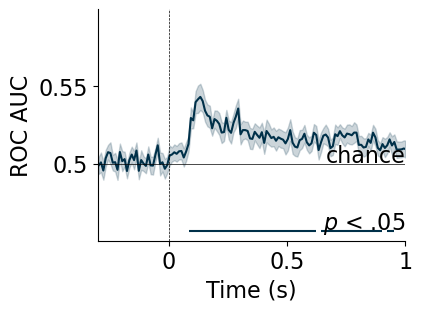

In [13]:
data_dict_id = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["id1", "id2", "id3"],
    vc_list=[""],  # , "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_id["all"] = data_dict_id.pop("")

fig, ax = plt.subplots(1, figsize=(9.3 * cm, 7 * cm))
prep_and_plot_from_data(data_dict_id, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

# set xticks to only 0, 0.5 and 1
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0.5, 0.55])
ax.set_yticklabels([0.5, 0.55])

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_identity_emo-all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

# fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
# prep_and_plot_from_data(
#     data_dict=data_dict_id,
#     subsets=["stereo", "mono"],
#     ax=ax,
#     chancelvl=0.333,
#     ylims=(0.3, 0.4),
# )

# Plot patterns

In [49]:
sub_patterns, pat_times = load_patterns(
    sub_list_str,
    contrast_str="surprised_vs_neutral",  # "mono_vs_stereo",  #'surprised_vs_neutral_vs_angry_vs_happy',  #   #
    viewcond="",  # "stereo",  # "mono", # ,
    scoring="roc_auc_ovr",
    reg="",
    labels_shuffled=False,
)

sub_patterns = sub_patterns[:, :, :]
sub_patterns_norm = np.zeros_like(sub_patterns)
# normalize them by L2 norm to allow for unbiased averages:
for sub in range(sub_patterns.shape[0]):
    for time in range(sub_patterns.shape[-1]):
        sub_patterns_norm[sub, :, time] = sub_patterns[sub, :, time] / l2norm(sub_patterns[sub, :, time])
sub_patterns_avg = sub_patterns_norm.copy().mean(axis=0)
sub_patterns_avg_norm = np.stack(
    [sub_patterns_avg[:, ii] / l2norm(sub_patterns_avg[:, ii]) for ii in range(sub_patterns_avg.shape[-1])],
    axis=-1,
)

# Build new pseudo Evoke obj:
dummy_epos_info = get_info()
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
info = mne.create_info(ch_names=dummy_epos_info.ch_names, sfreq=(1 / np.median(np.diff(pat_times))), ch_types="eeg")
info.set_montage(easycap_montage)
sub_patterns_evo = EvokedArray(sub_patterns_avg_norm, info, tmin=pat_times[0])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


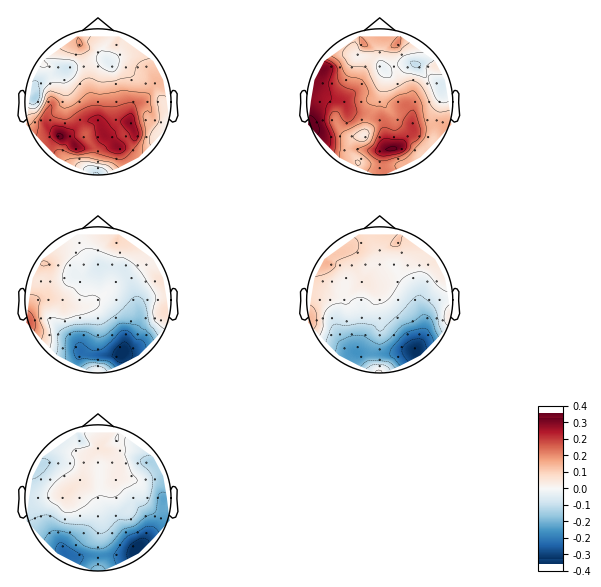

In [19]:
save_fig = True

times_plot = [0.0, 0.1, 0.13, 0.16, 0.2, 0.4, 0.6]

fig, ax = plt.subplots(3, 3, figsize=(16.6 * cm, 15 * cm), gridspec_kw={"width_ratios": [10, 10, 1]})

aaxx = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0]]

for tt, axi in zip(times_plot, aaxx, strict=False):
    # axii = fig.add_subplot(axi)
    t_plot = [tt]
    plt_load = sub_patterns_evo.plot_topomap(
        times=t_plot,
        scalings=1,
        units="",
       #  title="",  # f"{ecc_cond} -- Decod. Target: {config.labels['Load']}",
        cmap="RdBu_r",
        # vmin = -0.3,
        # vmax=0.3,
        contours=10,
        ch_type="eeg",
        extrapolate="local",
        axes=[ax[axi[0], axi[1]], ax[2, 2]],
        show=False,
    )
    ax[axi[0], axi[1]].set_title("")
# cb = ax.figure.colorbar(plt_load, ax=ax_cb)
fig.delaxes(ax[0][2])
fig.delaxes(ax[1][2])
fig.delaxes(ax[2][1])
plt.show()


if save_fig:
    # save it:
    fig.savefig(Path(paths.FIGURES, "topomap_decod_mono_vs_stereo.pdf"), transparent=True, bbox_inches="tight")

In [119]:
def get_fsavg_src(from_disk=False):  # noqa: D103
  fs_dir = fetch_fsaverage(verbose=False)
  src_path = Path(fs_dir, "bem", "fsaverage" + "-oct6" + "-src.fif")
  if not from_disk:
    subjects_dir = Path(fs_dir).parent
    src = mne.setup_source_space("fsaverage", spacing="oct6", subjects_dir=subjects_dir, add_dist=False)
    src.save(src_path, overwrite=True)
  else:
    src = mne.read_source_spaces(src_path)
  return src


def create_fake_info(epos, pattern_times):
  info = mne.create_info(ch_names=epos.ch_names, sfreq=1 / np.median(np.diff(pattern_times)), ch_types="eeg")
  info.set_montage(easycap_montage)
  return info


def get_fwd_solution(src, info, from_disk=False):
  config = CONFIG()
  fs_dir = fetch_fsaverage(verbose=True)
  path_fwd = Path(fs_dir, "bem", "fsaverage" + "-oct6" + "-fwd.fif")
  if not from_disk:
    fwd = mne.make_forward_solution(
        info, trans="fsaverage", src=src, bem=Path(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif"),
        eeg=True, n_jobs=config.N_JOBS
    )
    mne.write_forward_solution(path_fwd, fwd, overwrite=True, verbose=None)
  else:
    fwd = mne.read_forward_solution(path_fwd)
  return fwd


def get_inv_operator(fwd, epos, pattern_times):
    noise_cov = mne.compute_covariance(epos, tmax=0)
    # Build new pseudo Evoke obj so we can adapt sfreq:
    easycap_montage = mne.channels.make_standard_montage("easycap-M1")
    info = mne.create_info(ch_names=epos.ch_names, sfreq=1 / np.median(np.diff(pattern_times)), ch_types="eeg")
    info.set_montage(easycap_montage)
    inv_op = mne.minimum_norm.make_inverse_operator(
        epos.info,
        fwd,
        noise_cov,
        fixed=True,
        loose=0.2,
        depth=0.8,  # ignored by eLoreta
    )
    return inv_op, info


def get_src_timecourse(sub_id, contrast, pattern, pattern_times, inv_op, info, from_disk=False):
    paths = PATHS()
    fpath = Path(paths.DATA_04_DECOD_SENSORSPACE, contrast, "patterns", "src_timecourses", f"{sub_id}-stc.fif")
    if not from_disk:
        sub_pattern_src = EvokedArray(pattern, info, tmin=pattern_times[0])
        inst = sub_pattern_src.set_eeg_reference("FCz", projection=True)
        inst.data = sub_pattern_src.data
        stc = abs(
            mne.minimum_norm.apply_inverse(inst, inv_op, 0.1, "eLORETA", verbose=True)
        )
        stc.save(fpath)
    else:
        stc = mne.read_source_estimate(fpath)
    return stc


def process_sub(sub_id, contrast, sub_pattern, pat_times):
# Get the source space and the forward solution (needs to be done only once)
    src = get_fsavg_src(from_disk=True)
    epos = get_epos(sub_id)
    info = create_fake_info(epos, pat_times)
    fwd = get_fwd_solution(src, info, from_disk=True)  # takes a long time if not read from disc
    info = create_fake_info(epos, pat_times)
    inv_op, info = get_inv_operator(fwd, epos, pat_times)
    stc = get_src_timecourse(sub_id, contrast, sub_pattern, pat_times, inv_op, info, from_disk=False)
    return stc

import multiprocessing as mp

contrast = "surprised_vs_neutral"

sub_patterns, pat_times = load_patterns(
    sub_list_str,
    contrast_str=contrast,  # "mono_vs_stereo",  #'surprised_vs_neutral_vs_angry_vs_happy',  #   #
    viewcond="",  # "stereo",  # "mono", # ,
    scoring="roc_auc_ovr",
    reg="",
    labels_shuffled=False,
)

args = zip(sub_list_str, contrast, sub_patterns, pat_times)  # noqa: B905

with mp.Pool(len(sub_list_str)) as pool:
    source_tcs = pool.starmap(process_sub, args)




    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
0 files missing from root.txt in /u/fklotzsche/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage
Reading forward solution from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-oct6-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (8196 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: 

KeyboardInterrupt: 

In [44]:
def get_stc(sub_id, contrast):
  paths = PATHS()
  fpath = Path(paths.DATA_04_DECOD_SENSORSPACE, contrast, "roc_auc_ovr", "patterns", "src_timecourses", f"{sub_id}")
  stc = mne.read_source_estimate(fpath)
  return stc

In [47]:
    
def prep_mean_stc(stcs):
    stc_avg = np.array([st.data for st in stcs])

    # normalize per participant and time step by L2 norm to allow for unbiased averages:
    stc_avg_norm = np.zeros_like(stc_avg)
    for sub in range(stc_avg.shape[0]):
        stc_avg_norm[sub, :, :] = stc_avg[sub, :, :] / sum(stc_avg[sub, :, :])
        #for time in range(stc_avg.shape[-1]):
        #    stc_avg_norm[sub, :, time] = stc_avg[sub, :, time] / sum(stc_avg[sub, :, time])

    # avg across participants
    stc_mean_data = np.mean(stc_avg_norm, axis=0)
    stc_mean = stcs[0].copy()  # use as template to get the metadata
    stc_mean.data = stc_mean_data
    stc_mean.subject = "fsaverage"
    return stc_mean


def plot_stc(stc, time=0.2):
    kwargs = dict(
        initial_time=time,
        hemi="rh",
        subjects_dir=subjects_dir,
        size=(600, 600),  # clim={'lims':(50, 75, 95), 'kind': 'percent'},  # (0, 10, 20)},
        colormap="hot",
        # transparent=False,
        background="white",
        smoothing_steps=7,
        backend="matplotlib",
        views="par",
        clim={"kind":"percent", "lims":(95, 97.5, 99.9)}
    )
    stc.plot(**kwargs)

Using control points [0.0001819  0.00019472 0.00024581]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


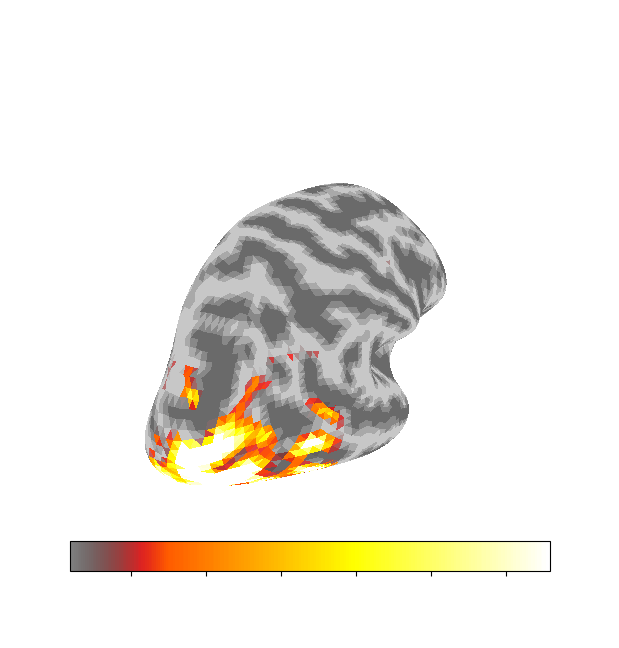

Using control points [0.0001797  0.00019271 0.00024013]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


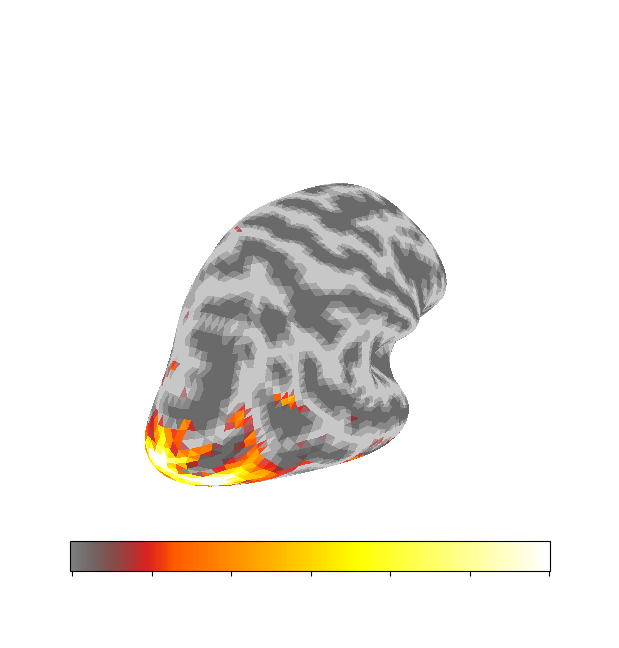

Using control points [0.00017946 0.00019331 0.0002475 ]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


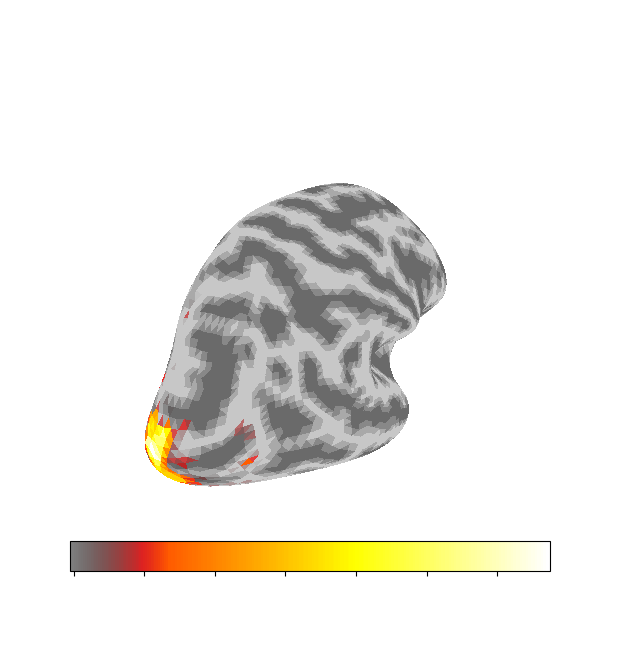

Using control points [0.00017943 0.00019221 0.00023983]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


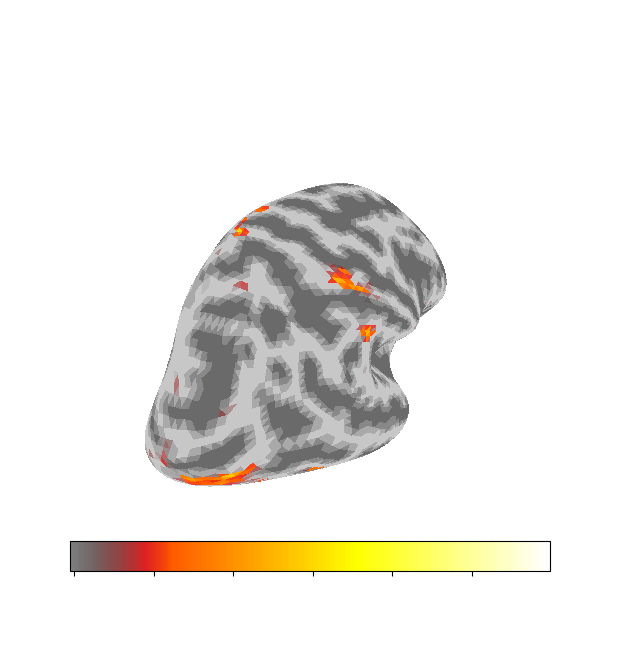

In [48]:
stcs = dict()
contrasts = ["mono_vs_stereo", "angry_vs_neutral", "angry_vs_happy", "happy_vs_neutral"]
for c in contrasts:
    stcs[c] = []
    for sub_id in sub_list_str:
        stc = get_stc(sub_id, c)
        stcs[c].append(stc)
        
for c in contrasts:
    stc_m = prep_mean_stc(stcs[c])
    plot_stc(stc_m, 0.170)

Using control points [0.00019328 0.00020808 0.00032999]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


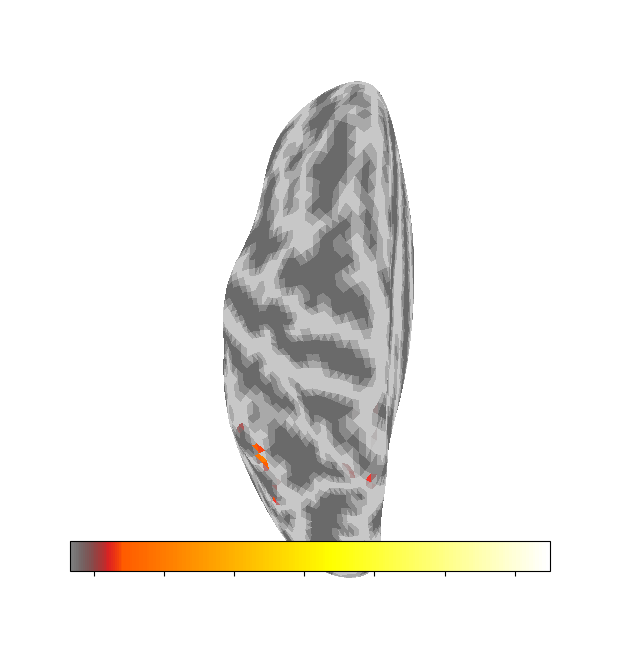

Using control points [0.00018613 0.00019472 0.00025805]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


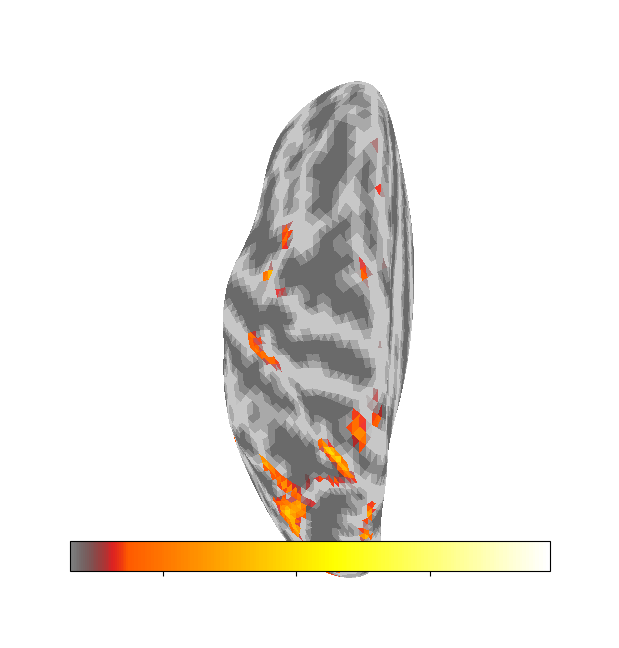

Using control points [0.00018946 0.00020153 0.00030175]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


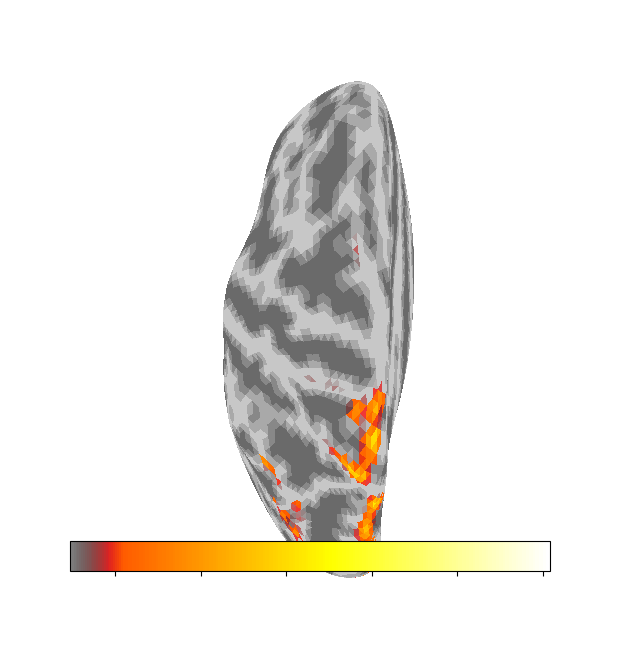

In [74]:
stc_m = prep_mean_stc(stcs["neutral_vs_happy_vs_angry_vs_surprised"])
plot_stc(stc_m, 0.8)
stc_m = prep_mean_stc(stcs["mono_vs_stereo"])
plot_stc(stc_m, 0.8)
stc_m = prep_mean_stc(stcs["id1_vs_id2_vs_id3"])
plot_stc(stc_m, 0.8)